**Objective**: Implement contrastive representation learning with SimCLR on small dataset using Pytorch

Source: https://medium.com/analytics-vidhya/understanding-simclr-a-simple-framework-for-contrastive-learning-of-visual-representations-d544a9003f3c

In [1]:
# Useful imports
import numpy as np
import torch
from torchvision import transforms as T
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18

import os
from PIL import Image
from collections import OrderedDict
import random

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE()

# Some useful imports to get resnet SimCLR results folder
import requests
import zipfile
import io

In [2]:
# Getting simCLR results folder
r = requests.get('https://github.com/thunderInfy/resnet-simclr/blob/master/results.zip?raw=true')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()   

# Image Dataset

In [3]:
# Getting the dataset from the github repo of imagenet 5 categories
!git clone https://github.com/thunderInfy/imagenet-5-categories.git

Cloning into 'imagenet-5-categories'...
remote: Enumerating objects: 1532, done.
remote: Total 1532 (delta 0), reused 0 (delta 0), pack-reused 1532
Receiving objects: 100% (1532/1532), 88.56 MiB | 22.87 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [33]:
# device is set to cuda if cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# root folder is the name of the folder where data is contained
root_folder = 'imagenet-5-categories'

train_names = sorted(os.listdir(root_folder + '/train'))
test_names = sorted(os.listdir(root_folder + '/test'))

# Only keeping car, elephant, and airplane picture for a smaller dataset
small_train = []
for x in train_names:
  if x.split('_')[0] not in ['dog', 'cat']:
    small_train.append(x)
small_test = []
for x in test_names:
  if x.split('_')[0] not in ['dog', 'cat']:
    small_test.append(x)

# setting random seed to ensure the same 10% labelled data is used when training the linear classifier
random.seed(5)
names_train_10_percent = random.sample(small_train, len(small_train)//10)
names_train = random.sample(small_train, len(small_train))
names_test = random.sample(small_test, len(small_test))

In [34]:
# defining a mapping between class names and numbers
mapping = {'car': 0,'elephant': 1, 'airplane': 2}
inverse_mapping = ['car','elephant', 'airplane']

# getting labels based on filenames, note that the filenames themselves contain classnames
# also note that these labels won't be used to actually train the base model
# these are just for visualization purposes
labels_train = [mapping[x.split('_')[0]] for x in names_train]
labels_test = [mapping[x.split('_')[0]] for x in names_test]

# these 10 percent labels will be used for training the linear classifer
labels_train_10_percent = [mapping[x.split('_')[0]] for x in names_train_10_percent]

print("Number of train images:", len(labels_train))
print("Number of test images:", len(labels_test))
print("10% of training data with labels:", len(labels_train_10_percent))

Number of train images: 750
Number of test images: 150
10% of training data with labels: 75


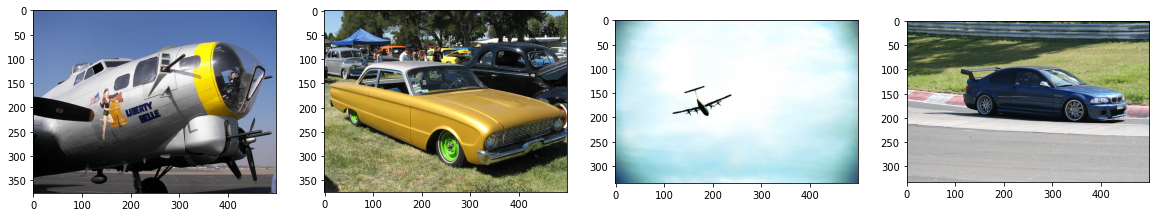

In [35]:
fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    image = Image.open(os.path.join(root_folder + '/train', names_train[i]))
    ax.imshow(image)

## Augmentation
Generate augmented image with 
* Random Crop and Resize
* Color Distortion


In [36]:
def get_color_distortion(s=1.0):
    # s is the strength of color distortion.
    color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)
    rnd_gray = T.RandomGrayscale(p=0.2)
    color_distort = T.Compose([rnd_color_jitter, rnd_gray])
    return color_distort

class MyDataset(Dataset):
    def __init__(self, root_dir, filenames, labels, mutation=False):
        self.root_dir = root_dir
        self.file_names = filenames
        self.labels = labels
        self.mutation = mutation

    def __len__(self):
        return len(self.file_names)

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img) # Random Crop and Resize
        res = get_color_distortion(1)(res) # Color Distortion
        return res

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name)
        label = self.labels[idx]
        image = T.Resize((250, 250))(image)

        if self.mutation:
            image1 = self.mutate_image(image)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(image)
            image2 = self.tensorify(image2)
            sample = {'image1': image1, 'image2': image2, 'label': label}
        else:
            image = T.Resize((224, 224))(image)
            image = self.tensorify(image)
            sample = {'image': image, 'label': label}

        return sample

## Preprocessing

In [37]:
# Data Augmentation on training
training_dataset_mutated = MyDataset(root_folder + '/train', names_train, labels_train, mutation=True) # original image
training_dataset = MyDataset(root_folder + '/train', names_train_10_percent, labels_train_10_percent, mutation=False)
testing_dataset = MyDataset(root_folder + '/test', names_test, labels_test, mutation=False)

In [38]:
# DataLoader takes a dataset and returns batches of images and coresponding labels
dataloader_training_dataset_mutated = DataLoader(training_dataset_mutated, batch_size=50, shuffle=True, num_workers=2) 
dataloader_training_dataset = DataLoader(training_dataset, batch_size=15, shuffle=True, num_workers=2)
dataloader_testing_dataset = DataLoader(testing_dataset, batch_size=50, shuffle=True, num_workers=2)

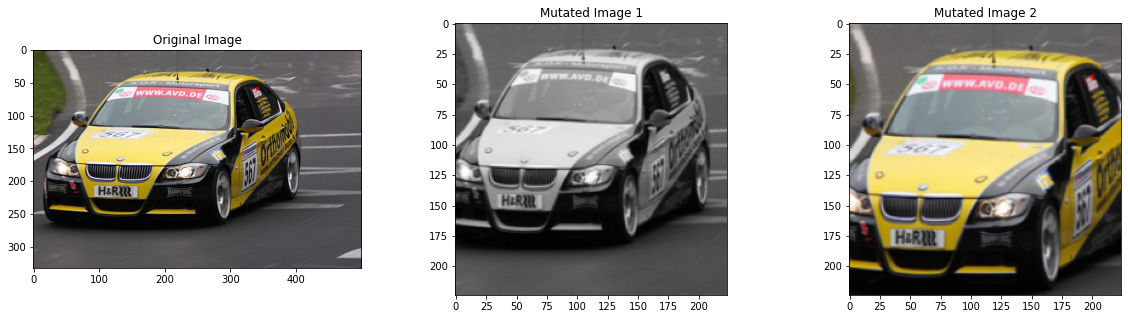

In [49]:
def deprocess_and_show(img_tensor):
    return T.Compose([
            T.Normalize((0, 0, 0), (2, 2, 2)),
            T.Normalize((-0.5, -0.5, -0.5), (1, 1, 1)),
            T.ToPILImage()
          ])(img_tensor)

f, axarr = plt.subplots(1,3, figsize=(20,5)) 
sample = 12
axarr[0].imshow(Image.open(os.path.join(root_folder + '/train', names_train[sample])))
axarr[0].set(title = "Original Image")
axarr[1].imshow(deprocess_and_show(training_dataset_mutated[sample]['image1']))
axarr[1].set(title = "Mutated Image 1")
axarr[2].imshow(deprocess_and_show(training_dataset_mutated[sample]['image1']))
axarr[2].set(title = "Mutated Image 2")
plt.show()

# SimCLR Framework

## Contrastive Loss (NT-XEnt)
* Augmented image should have similar representations as original image
* Goal - Maximized the agreement (cosine similarity) between these image by minimizing the contrastive loss (Normalized Temperature-Scaled Cross-Entropy Loss) between the vectors 

In [50]:
def loss_function(a,b,tau):
    a_norm = torch.norm(a,dim=1).reshape(-1,1)
    a_cap = torch.div(a,a_norm)
    b_norm = torch.norm(b,dim=1).reshape(-1,1)
    b_cap = torch.div(b,b_norm)
    a_cap_b_cap = torch.cat([a_cap,b_cap],dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap,a_cap],dim=0)
    sim = torch.mm(a_cap_b_cap,a_cap_b_cap_transpose) # similarity matrix
    sim_by_tau = torch.div(sim,tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap,b_cap_a_cap),tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators,denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

## ResNet18 Model

In [51]:
# Load Resnet
resnet = resnet18(pretrained=False)

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(resnet.fc.in_features, 100)),
    ('added_relu1', nn.ReLU(inplace=True)),
    ('fc2', nn.Linear(100, 50)),
    ('added_relu2', nn.ReLU(inplace=True)),
    ('fc3', nn.Linear(50, 25))
]))

resnet.fc = classifier

## Training Step

In [52]:
# Defining data structures for storing training info
losses_train = []
num_epochs = 10
tau = 0.05 # Temperature

# Using SGD optimizer
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

if not os.path.exists('results'):
    os.makedirs('results')

In [53]:
# get resnet in train mode
resnet.train()

for epoch in range(num_epochs):
    epoch_losses_train = []
    for (_, sample_batched) in enumerate(dataloader_training_dataset_mutated):
        optimizer.zero_grad()
        # retrieve x1 and x2 the two image batches
        x1 = sample_batched['image1']
        x2 = sample_batched['image2']

        # get their outputs
        y1 = resnet(x1)
        y2 = resnet(x2)

        loss = loss_function(y1, y2, tau)
        epoch_losses_train.append(loss.data.item())
        loss.backward()
        optimizer.step()

    # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
    loss_avg = sum(epoch_losses_train)/len(epoch_losses_train)
    losses_train.append(loss_avg)
    print("Epoch:", epoch)
    print("Loss =", loss_avg)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0
Loss = 4.634858131408691
Epoch: 1
Loss = 4.5506007194519045
Epoch: 2
Loss = 4.512076282501221
Epoch: 3
Loss = 4.479902521769206
Epoch: 4
Loss = 4.424866422017415
Epoch: 5
Loss = 4.410908889770508
Epoch: 6
Loss = 4.403158187866211
Epoch: 7
Loss = 4.319943237304687
Epoch: 8
Loss = 4.370066483815511
Epoch: 9
Loss = 4.37835480372111


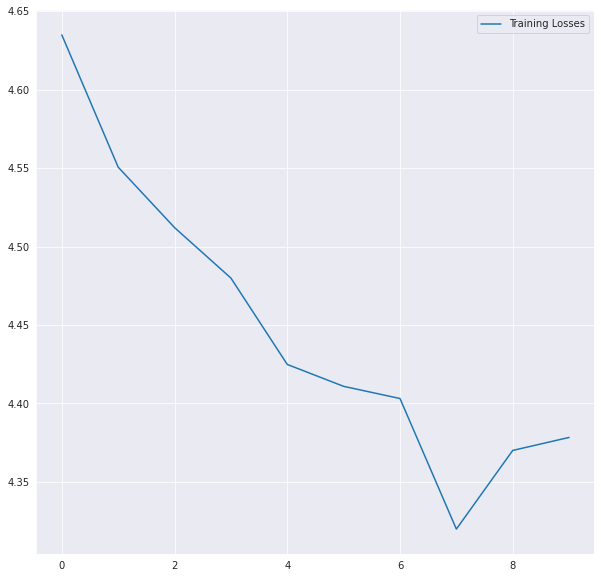

In [54]:
fig = plt.figure(figsize=(10, 10))
sns.set_style('darkgrid')
plt.plot(losses_train)
plt.legend(['Training Losses'])
plt.show()

# Evaluation Comparison

## Linear Model

In [57]:
class LinearNet(nn.Module):
  def __init__(self):
      super(LinearNet, self).__init__()
      self.fc1 = torch.nn.Linear(25, 5)

  def forward(self, x):
      x = self.fc1(x)
      return(x)

In [58]:
linear_classifier = LinearNet()
linear_optimizer = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)

#number of epochs
num_epochs_linear = 10

# Defining data structures to store train and test info for linear classifier
losses_train_linear, acc_train_linear  = [], []
losses_test_linear, acc_test_linear = [], []

# a variable to keep track of the maximum test accuracy, will be useful to store 
# model parameters with the best test accuracy
max_test_acc = 0

# Run a for loop for training the linear classifier
for epoch in range(num_epochs_linear):
  print("Epoch:", epoch)
  # run linear classifier in train mode
  linear_classifier.train()
  # a list to store losses for each batch in an epoch
  epoch_losses_train_linear = []
  epoch_acc_train_num_linear = 0.0
  epoch_acc_train_den_linear = 0.0

  # for loop for running through each batch
  for (_, sample_batched) in enumerate(dataloader_training_dataset):
      x = sample_batched['image']
      y_actual = sample_batched['label']
      y_intermediate = resnet(x)
      linear_optimizer.zero_grad()
      y_predicted = linear_classifier(y_intermediate)
      loss = nn.CrossEntropyLoss()(y_predicted, y_actual)
      epoch_losses_train_linear.append(loss.data.item())
      loss.backward()
      linear_optimizer.step()

      # get predictions and actual values
      pred = np.argmax(y_predicted.data, axis=1)
      actual = y_actual.data
      #update the numerators and denominators of accuracy
      epoch_acc_train_num_linear += (actual == pred).sum().item()
      epoch_acc_train_den_linear += len(actual)

  # update losses and acc lists    
  train_loss_avg = sum(epoch_losses_train_linear)/len(epoch_losses_train_linear)
  losses_train_linear.append(train_loss_avg)
  train_acc = epoch_acc_train_num_linear / epoch_acc_train_den_linear
  acc_train_linear.append(train_acc)
  print("Train Loss =", train_loss_avg, "Train Accuracy =",train_acc)

  # run linear classifier in eval mode
  linear_classifier.eval()

  # essential variables to keep track of losses and acc
  epoch_losses_test_linear = []
  epoch_acc_test_num_linear = 0.0
  epoch_acc_test_den_linear = 0.0

  # run a for loop through each batch
  for (_, sample_batched) in enumerate(dataloader_testing_dataset):
      x = sample_batched['image']
      y_actual = sample_batched['label']
      y_intermediate = resnet(x)

      y_predicted = linear_classifier(y_intermediate)
      loss = nn.CrossEntropyLoss()(y_predicted, y_actual)
      epoch_losses_test_linear.append(loss.data.item())

      pred = np.argmax(y_predicted.data, axis=1)
      actual = y_actual.data
      epoch_acc_test_num_linear += (actual == pred).sum().item()
      epoch_acc_test_den_linear += len(actual)

  test_acc = epoch_acc_test_num_linear / epoch_acc_test_den_linear
  acc_test_linear.append(test_acc)
  test_loss_avg = sum(epoch_losses_test_linear)/len(epoch_losses_test_linear)
  losses_test_linear.append(test_loss_avg)
  print("Test Loss =", test_loss_avg, "Test Accuracy =", test_acc)

Epoch: 0
Train Loss = 1.5217474460601808 Train Accuracy = 0.14666666666666667
Test Loss = 1.3439925114313762 Test Accuracy = 0.3333333333333333
Epoch: 1
Train Loss = 1.2077013015747071 Train Accuracy = 0.37333333333333335
Test Loss = 1.1746935844421387 Test Accuracy = 0.35333333333333333
Epoch: 2
Train Loss = 1.080974268913269 Train Accuracy = 0.49333333333333335
Test Loss = 1.0929982662200928 Test Accuracy = 0.5466666666666666
Epoch: 3
Train Loss = 1.0211082696914673 Train Accuracy = 0.5733333333333334
Test Loss = 0.9986074964205424 Test Accuracy = 0.5133333333333333
Epoch: 4
Train Loss = 0.964512038230896 Train Accuracy = 0.56
Test Loss = 0.9562154014905294 Test Accuracy = 0.5333333333333333
Epoch: 5
Train Loss = 0.9196633696556091 Train Accuracy = 0.6
Test Loss = 0.9299098054567972 Test Accuracy = 0.5533333333333333
Epoch: 6
Train Loss = 0.9161475419998169 Train Accuracy = 0.5733333333333334
Test Loss = 0.9017063776652018 Test Accuracy = 0.5466666666666666
Epoch: 7
Train Loss = 0.88

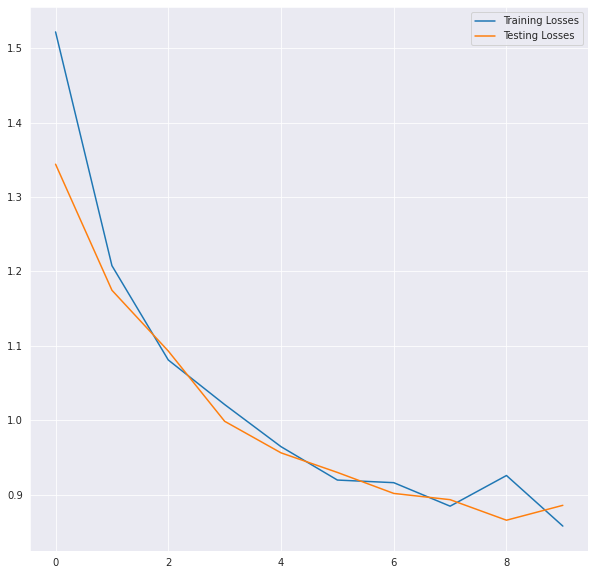

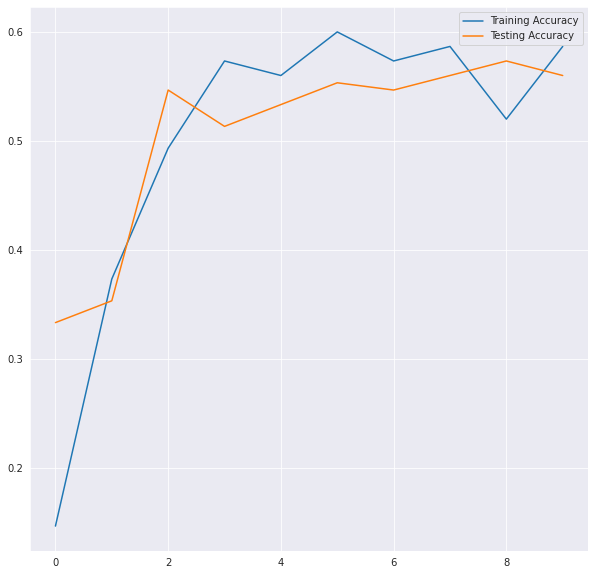

In [59]:
  # plotting losses and accuracies
  fig = plt.figure(figsize=(10, 10))
  sns.set_style('darkgrid')
  plt.plot(losses_train_linear)
  plt.plot(losses_test_linear)
  plt.legend(['Training Losses', 'Testing Losses'])
  plt.show()

  fig = plt.figure(figsize=(10, 10))
  sns.set_style('darkgrid')
  plt.plot(acc_train_linear)
  plt.plot(acc_test_linear)
  plt.legend(['Training Accuracy', 'Testing Accuracy'])
  plt.show()

# TSNE Visualization
Use t-SNE for plotting image cluster

In [95]:
# To plot t-SNE visualizations
def plot_vecs_n_labels(v,labels,fname):
    fig = plt.figure(figsize = (10, 10))
    plt.axis('off')
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 3))
    plt.legend(['elephant','car','airplane'])
    plt.savefig(fname)
    plt.close()

def plot_helper(resnet, dataset, fname):
  for (_, sample_batched) in enumerate(dataset):
    x = sample_batched['image']
    y = resnet(x)
    y_tsne = tsne.fit_transform(y.data)
    labels = sample_batched['label']
    plot_vecs_n_labels(y_tsne,labels,fname)

## ResNet in Evaluation Mode

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0.5, 1.0, 'Last Layer of Test')

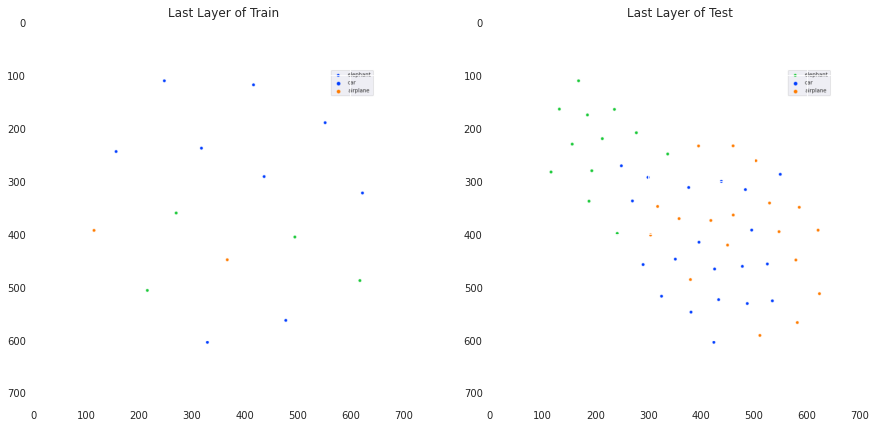

In [96]:
resnet.eval()
plot_helper(resnet, dataloader_training_dataset, 'tsne_train_last_layer.png') # 10% training dataset
plot_helper(resnet, dataloader_testing_dataset, 'tsne_test_last_layer.png') #testing dataset

image1 = Image.open("/content/tsne_train_last_layer.png")
image2 = Image.open("/content/tsne_test_last_layer.png")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(image1)
axes[0].set_title('Last Layer of Train')
axes[1].imshow(image2)
axes[1].set_title('Last Layer of Test')

## ResNet with Removal of last layer and the relu layer

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0.5, 1.0, 'Second Last Layer of Test')

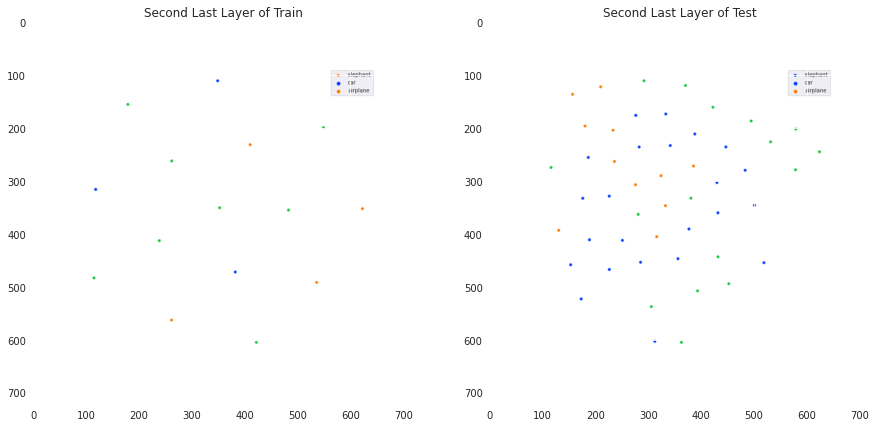

In [97]:
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-2])
plot_helper(resnet, dataloader_training_dataset, 'tsne_train_second_last_layer.png')
plot_helper(resnet, dataloader_testing_dataset, 'tsne_test_second_last_layer.png')

image1 = Image.open("/content/tsne_train_second_last_layer.png")
image2 = Image.open("/content/tsne_test_second_last_layer.png")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(image1)
axes[0].set_title('Second Last Layer of Train')
axes[1].imshow(image2)
axes[1].set_title('Second Last Layer of Test')

## ResNet with Removal of one more layer


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

Text(0.5, 1.0, 'Second Last Layer of Test')

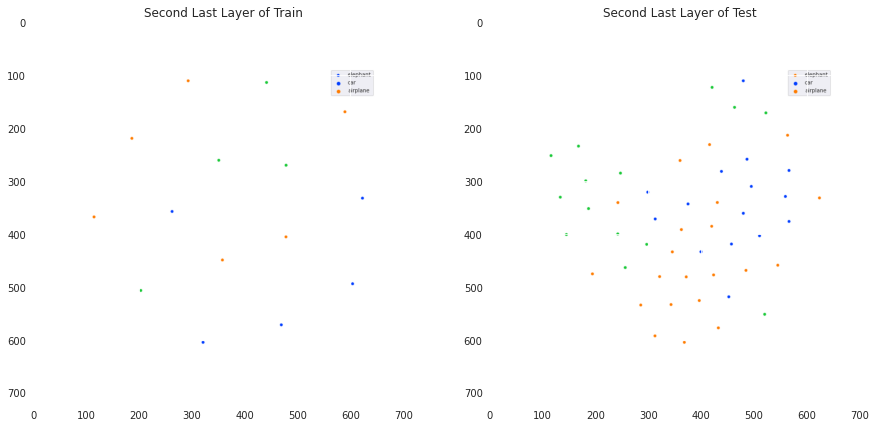

In [98]:
resnet.fc = nn.Sequential(*list(resnet.fc.children())[:-1])
plot_helper(resnet, dataloader_training_dataset, 'tsne_hidden_train.png')
plot_helper(resnet, dataloader_testing_dataset, 'tsne_hidden_test.png')

image1 = Image.open("/content/tsne_hidden_train.png")
image2 = Image.open("/content/tsne_hidden_test.png")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(image1)
axes[0].set_title('Second Last Layer of Train')
axes[1].imshow(image2)
axes[1].set_title('Second Last Layer of Test')